In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import keras as keras
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LambdaCallback
from keras.layers import Lambda
from keras.models import Model
from sklearn.utils import shuffle
# standard numerical library imports
import numpy as np
import scipy as sp
from scipy.signal import argrelmin, argrelmax

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

import inspect

Using TensorFlow backend.


In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [4]:
print(keras.__version__)  #2.2.4
print(tf.__version__)  #1.15.0

2.2.4
1.15.0


# Alternative DCTR fitting algorithm for $\alpha_s$

This notebook uses DCTR Reweightor paramterized by $\alpha_s$ on the full phase space to perform the alternative fitting algorithm on an unknown dataset. 

## Load and Process Data

### Utilities

In [5]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:, 0] > 0
    yphi_avg = np.average(x[mask, 1:3], weights=x[mask, 0], axis=0)
    x[mask, 1:3] -= yphi_avg
    x[mask, 0] /= x[:, 0].sum()

In [6]:
def preprocess_data(X):
    for x in X:
        normalize(x)

    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

### Process data

In [7]:
# Path to downloaded data from Zenodo
data_dir = '/data0/users/aandreassen/zenodo/'

In [8]:
default_dataset = np.load(data_dir + 'test1D_default.npz')
unknown_dataset = np.load(data_dir + 'test1D_alphaS.npz')

In [9]:
X_default = preprocess_data(default_dataset['jet'][:, :, :4])
X_unknown = preprocess_data(unknown_dataset['jet'][:, :, :4])

Y_default = np.zeros_like(X_unknown[:, 0, 0])
Y_unknown = np.ones_like(X_unknown[:, 0, 0])

In [10]:
X_fit = np.concatenate((X_default, X_unknown), axis=0)

Y_fit = np.concatenate((Y_default, Y_unknown), axis=0)

In [11]:
X_train, X_test, Y_train, Y_test = data_split(X_fit,
                                              Y_fit,
                                              test=0.5,
                                              shuffle=True)

X_train_theta, _, Y_train_theta, _ = data_split(X_fit,
                                                Y_fit,
                                                test=0.9,
                                                shuffle=True)

## Loading DCTR Model

In [12]:
# network architecture parameters
Phi_sizes = (100, 100, 128)
F_sizes = (100, 100, 100)

dctr = PFN(input_dim=7, Phi_sizes=Phi_sizes, F_sizes=F_sizes, summary=False)

# load model from saved file
# model trained in original alphaS notebook
dctr.model.load_weights(
    './saved_models/DCTR_ee_dijets_1D_alphaS.h5')  #ORIGINAL DCTR

### Defining reweighting function

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [13]:
# Defining reweighting functions


def reweight(events, param):  #from NN (DCTR)
    theta_prime = [param, 0.68, 0.217]

    # zip theta_prime to each input particle (but not to the padded rows)
    # checks if pT != 0, which means we have a particle
    concat_input_and_params = tf.where(
        K.abs(events[..., 0]) > 0, K.ones_like(events[..., 0]),
        K.zeros_like(events[..., 0]))

    concat_input_and_params = theta_prime * K.stack([
        concat_input_and_params, concat_input_and_params,
        concat_input_and_params
    ],
                                                    axis=-1)

    model_inputs = K.concatenate([events, concat_input_and_params], -1)
    # Use dctr.model.predict_on_batch(d) when using outside training

    f = dctr.model(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights

# Alternative Fit

## Fitting Model: Scan

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

### Creating Model

In [14]:
model = PFN(input_dim=4,
            Phi_sizes=Phi_sizes,
            F_sizes=F_sizes,
            latent_dropout=0.2,
            F_dropouts=0.2,
            output_dim=1,
            output_act='sigmoid',
            summary=True)
myinputs = model.inputs[0]
batch_size = 1000

earlystopping = EarlyStopping(patience=10, restore_best_weights=True)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_8 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_8[0][0]         

In [15]:
def my_loss_wrapper(inputs,
                    val=0,
                    loss='categorical_crossentropy',
                    batch_size=1000):
    x = inputs
    # x.shape = (?,?,4)
    # Reshaping to correct format
    x = tf.gather(x, np.arange(batch_size))
    # Axis corressponds to (max) number of particles in each event:
    x = tf.gather(x, np.arange(51), axis=1)

    weights = reweight(events=x, param=val)

    def my_loss(y_true, y_pred):
        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + weights * (
                1. - y_true) * (y_true - y_pred)**2
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")

        return (K.mean(t_loss))

    return my_loss

### Training Model

In [16]:
thetas = np.linspace(0.10, 0.18, 33)  # iterating across possible alphaS values
lvals = []
vlvals = []

for theta in thetas:
    print("Testing theta = ", theta)
    model.model.compile(optimizer='adam',
                        loss=my_loss_wrapper(myinputs,
                                             theta,
                                             batch_size=batch_size),
                        metrics=['accuracy'])

    history = model.fit(X_train,
                        Y_train,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(X_test, Y_test),
                        verbose=0,
                        callbacks=[earlystopping])

    min_lval = history.history['loss'][np.argmin(history.history['val_loss'])]
    min_vlval = np.min(history.history['val_loss'])

    lvals += [min_lval]
    vlvals += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")

    print
    pass

Testing theta =  0.1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


loss:  0.6104381495051914
val_loss:  0.6088239901595646


Testing theta =  0.10250000000000001
loss:  0.6124995698531469
val_loss:  0.6138319092326694


Testing theta =  0.10500000000000001
loss:  0.6171404641866683
val_loss:  0.6175125716792212


Testing theta =  0.1075
loss:  0.6204162424140506
val_loss:  0.621958215104209


Testing theta =  0.11
loss:  0.6250521253877216
val_loss:  0.6275202306111654


Testing theta =  0.1125
loss:  0.6304239847924974
val_loss:  0.6334475459655126


Testing theta =  0.115
loss:  0.6360400182671017
val_loss:  0.639401105509864


Testing theta =  0.11750000000000001
loss:  0.6414902230766084
val_loss:  0.6439054591125912


Testing theta =  0.12
loss:  0.646970123052597
val_loss:  0.6501973916424645


Testing theta =  0.1225
loss:  0.6519328716066148
val_loss:  0.6553430723481708


Testing theta =  0.125
loss:  0.6563334739208222
val_los

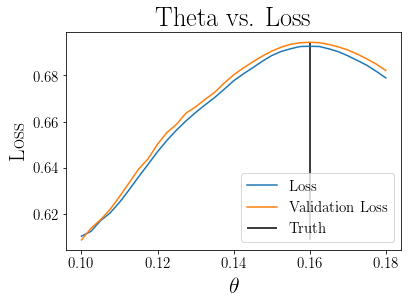

In [17]:
plt.title("Theta vs. Loss")
plt.plot(thetas, lvals, label='Loss')
plt.plot(thetas, vlvals, label='Validation Loss')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(0.160,
           ymin=np.min(lvals + vlvals),
           ymax=np.max(lvals + vlvals),
           label='Truth')
plt.legend()
# plt.savefig("DCTR_1D_alphaS_AltFit-Theta-vs-Loss.png")
plt.show()

## Fitting Model: Gradient Descent

### Creating Model

In [18]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(
    "Theta fit = ", model_fit.layers[-1].get_weights()[-1]))

theta_fit_init = 0.12
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(
    on_epoch_end=lambda batch, logs: fit_vals.append(model_fit.layers[-1].
                                                     get_weights()[0]))

callbacks = [print_weights, append_fit_value]

earlystopping = EarlyStopping(patience=10, restore_best_weights=True)

In [19]:
PFN_model = PFN(input_dim=4,
                Phi_sizes=Phi_sizes,
                F_sizes=F_sizes,
                latent_dropout=0.2,
                F_dropouts=0.2,
                output_dim=1,
                output_act='sigmoid',
                summary=False)
myinputs_fit = PFN_model.inputs[0]

identity = Lambda(lambda x: x + 0)(PFN_model.output)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers) - 1].add_weight(
    name="thetaX",
    shape=list(),
    initializer=keras.initializers.Constant(value=theta_fit_init),
    trainable=True)
model_fit.summary()

batch_size_g = 1000
batch_size_theta = int(len(X_train_theta) / 10.)
iterations = 50

# optimizer will be refined as fit progresses for better precision
lr_initial = 1e-2
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_15 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_15[0][0]              
__________________________________________________________________________________________________
activation

In [20]:
def my_loss_wrapper_fit(inputs,
                        mysign=1,
                        loss='categorical_crossentropy',
                        batch_size=1000):
    x = inputs
    x = K.gather(x, np.arange(batch_size))
    x = tf.gather(
        x, np.arange(51),
        axis=1)  # Axis corressponds to (max) number of particles in each event

    # Getting theta_prime:
    if mysign == 1:
        #  when not training theta, fetch as np array
        theta_prime = model_fit.layers[-1].get_weights()[0]
    else:
        # when training theta, fetch as tf.Variable
        theta_prime = model_fit.trainable_weights[-1]
    weights = reweight(x, theta_prime)  # NN reweight

    def my_loss(y_true, y_pred):
        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = mysign * (y_true * (y_true - y_pred)**2 + weights *
                               (1. - y_true) * (y_true - y_pred)**2)
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -mysign * ((y_true) * K.log(y_pred) + weights *
                                (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")

        return K.mean(t_loss)

    return my_loss

### Training Model

In [21]:
for iteration in range(iterations):
    print("Iteration: ", iteration + 1)
    # Reshuffling Training Data:
    X_train, X_test, Y_train, Y_test = data_split(X_fit,
                                                  Y_fit,
                                                  test=0.5,
                                                  shuffle=True)

    X_train_theta, _, Y_train_theta, _ = data_split(X_fit,
                                                    Y_fit,
                                                    test=0.9,
                                                    shuffle=True)

    # fix \theta and train g
    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = True
        pass
    model_fit.layers[-1].trainable = False
#     model.summary()

    # regular optimizer and batch size
    model_fit.compile(optimizer='Adam',
                      loss=my_loss_wrapper_fit(myinputs_fit,
                                               1,
                                               batch_size=batch_size_g),
                      metrics=['accuracy'])
    print("Training g")
    model_fit.fit(X_train,
                  Y_train,
                  epochs=100,
                  batch_size=batch_size_g,
                  validation_data=(X_test, Y_test),
                  verbose=0,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True

    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit(myinputs_fit,
                                               -1,
                                               batch_size=batch_size_theta),
                      metrics=['accuracy'])
#     model.summary()
    print("Training theta")
    model_fit.fit(X_train_theta,
                  Y_train_theta,
                  epochs=1,
                  batch_size=batch_size_theta,
                  verbose=0,
                  callbacks=callbacks)

    print("\n")

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_recent = np.array(fit_vals)[(index_refine[-1]):]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior

    extrema = np.concatenate(
        (argrelmin(fit_vals_recent)[0], argrelmax(fit_vals_recent)[0]))
    extrema = extrema[extrema >= iteration - index_refine[-1] - 20]

    if (len(extrema) >= 6):  # If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================\n')
        optimizer.lr = optimizer.lr / 10.

        mean_fit = np.array([
            np.mean(fit_vals_recent[len(fit_vals_recent) -
                                    4:len(fit_vals_recent)])
        ])

        model_fit.layers[-1].set_weights(mean_fit)
    pass

Iteration:  1
Training g
Training theta
Theta fit =  0.20728561


Iteration:  2
Training g
Training theta
Theta fit =  0.122420914


Iteration:  3
Training g
Training theta
Theta fit =  0.20852457


Iteration:  4
Training g
Training theta
Theta fit =  0.10581654


Iteration:  5
Training g
Training theta
Theta fit =  0.21594886


Iteration:  6
Training g
Training theta
Theta fit =  0.09179292


Iteration:  7
Training g
Training theta
Theta fit =  0.22011091


====Refining Learning Rate====

Iteration:  8
Training g
Training theta
Theta fit =  0.15908727


Iteration:  9
Training g
Training theta
Theta fit =  0.16160056


Iteration:  10
Training g
Training theta
Theta fit =  0.15637684


Iteration:  11
Training g
Training theta
Theta fit =  0.16798459


Iteration:  12
Training g
Training theta
Theta fit =  0.15080442


Iteration:  13
Training g
Training theta
Theta fit =  0.16892034


Iteration:  14
Training g
Training theta
Theta fit =  0.15049364


====Refining Learning Rate====

Iterat

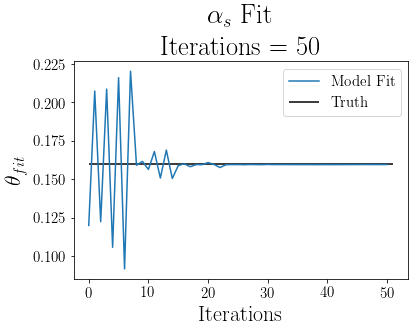

In [22]:
plt.figure()
plt.title(r'$\alpha_s$ Fit' + '\n Iterations = {:.0f}'.format(iterations))
plt.plot(fit_vals, label='Model Fit')
plt.hlines(0.16, 0, len(fit_vals), label='Truth')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig(
#     "DCTR_1D_alphaS_AltFit-\alphaS-Fit-Iterations = {}.png".format(iterations))
plt.show()

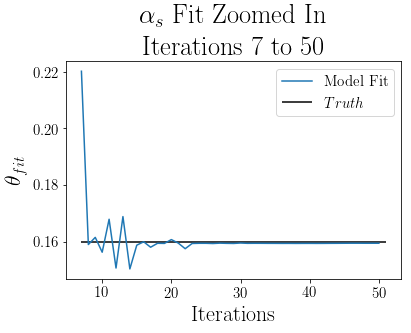

In [23]:
# Zoom into later iterations (finer fit)
fit_vals = np.array(fit_vals)
plt.title(r'$\alpha_s$ Fit Zoomed In' +
          '\nIterations {:.0f} to {:.0f}'.format(index_refine[1], iterations))
plt.plot(np.arange(index_refine[1], len(fit_vals)),
         fit_vals[index_refine[1]:],
         label='Model Fit')
plt.hlines(0.16, index_refine[1], len(fit_vals), label='$Truth$')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig(
#     "DCTR_1D_alphaS_AltFit-\alphaS-Fit-Zoomed-in-Iterations {} to {}.png".
#     format(index_refine[1], iterations))
plt.show()